# 3rd Notebook for Machine Learning Intro Lecture

## 1. How not to split: the good, the bad, the ugly

How does the choice of the split in train and test data affect the model?



### the good split

we train on the data 1:30 and test on 31:50. Remember, that iris is an ordered data set with the first 50 obsverations being setosa, the next 50 versicolor and the last 50 virginica. 

In [69]:
library(mlr)
library(ggplot2)

task = makeClassifTask(data = iris, target = "Species")
learner = makeLearner("classif.kknn", k = 3)
model = train(learner, task, subset = c(1:30))
pred = predict(model, task = task, subset = 31:50)
performance(pred, measures = mmce)
calculateConfusionMatrix(pred)

mmce 
   0

            predicted
true         setosa versicolor virginica -err.-
  setosa         20          0         0      0
  versicolor      0          0         0      0
  virginica       0          0         0      0
  -err.-          0          0         0      0

### the bad split

we train on the data 1:100 and test on 101:150.

In [70]:
task = makeClassifTask(data = iris, target = "Species")
learner = makeLearner("classif.kknn", k = 3)
model = train(learner, task, subset = c(1:100))
pred = predict(model, task = task, subset = 101:150)
performance(pred, measures = mmce)
calculateConfusionMatrix(pred)

mmce 
   1

            predicted
true         setosa versicolor virginica -err.-
  setosa          0          0         0      0
  versicolor      0          0         0      0
  virginica       0         50         0     50
  -err.-          0         50         0     50

### the ugly split


In [71]:
task = makeClassifTask(data = iris, target = "Species")
learner = makeLearner("classif.kknn", k = 3)
model = train(learner, task, subset = c(1:45, 51:95, 101:110))
pred = predict(model, task = task, subset = c(46:50, 96:100, 111:150))
performance(pred, measures = mmce)
calculateConfusionMatrix(pred)

mmce 
0.18

            predicted
true         setosa versicolor virginica -err.-
  setosa          5          0         0      0
  versicolor      0          5         0      0
  virginica       0          9        31      9
  -err.-          0          9         0      9

## 2. Overfitting kNN

Check the performance of our knn-classifier on the test and train set depending on the hyperparameter k:

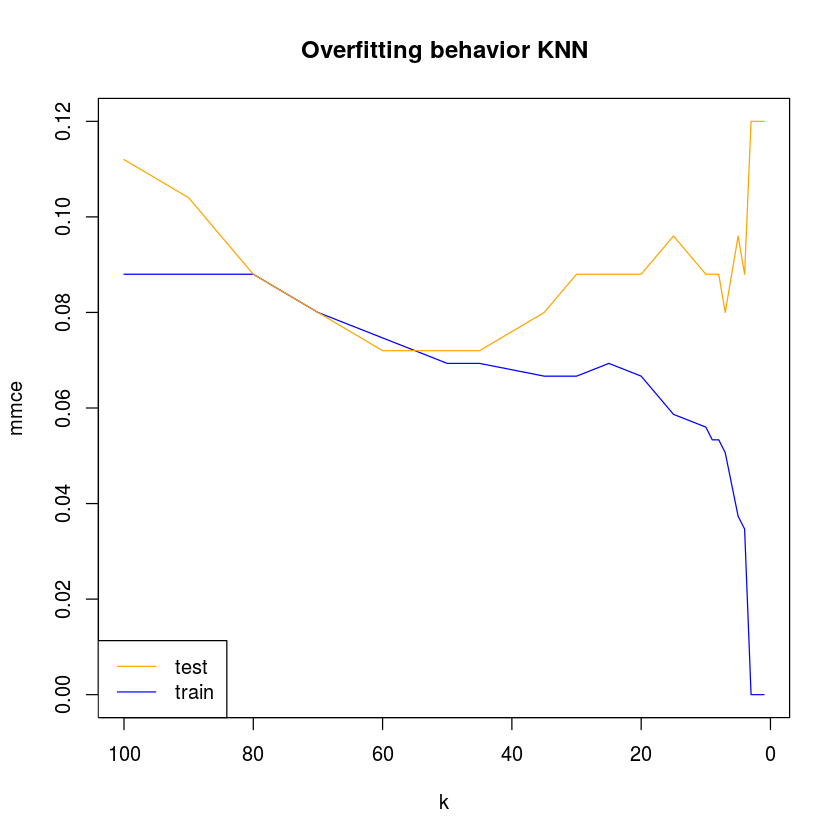

In [72]:
library(mlr)
library(mlbench)

set.seed(13)
spiral = as.data.frame(mlbench.spirals(n = 500, sd = 0.1))
trainSize = 3/4
trainIndices = sample(x = seq(1, nrow(spiral), by = 1), size = ceiling(trainSize * nrow(spiral)), replace = FALSE)
spiralTrain = spiral[ trainIndices, ]
spiralTest = spiral[ -trainIndices, ]



# run experiment
k.values = rev(c(1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 20, 25, 30, 35, 45, 50, 60, 70, 80, 90, 100))
storage = data.frame(matrix(NA, ncol = 3, nrow = length(k.values)))
colnames(storage) = c("mmce_train", "mmce_test", "k")

for (i in 1:length(k.values)) {

  spiralTask = makeClassifTask(data = spiralTrain, target = "classes")
  spiralLearner = makeLearner("classif.kknn", k = k.values[i])
  spiralModel = train(learner = spiralLearner, task = spiralTask)

  # test data
  # choose additional measures from: listMeasures(irisTask)
  spiralPred = predict(spiralModel, newdata = spiralTest[])
  storage[i, "mmce_test"] = performance(pred = spiralPred, measures = mmce)

  # train data
  spiralPred = predict(spiralModel, newdata = spiralTrain[])
  storage[i, "mmce_train"] = performance(pred = spiralPred, measures = mmce)

  storage[i, "k"] = k.values[i]
}

storage = storage[rev(order(storage$k)),]

plot(x = storage$k, y = storage$mmce_train, main = "Overfitting behavior KNN",
  xlab = "k", ylab = "mmce", col = "blue", type = "l",
  xlim = rev(range(storage$k)),
  ylim = c(min(storage$mmce_train, storage$mmce_test), 
    max(storage$mmce_train, storage$mmce_test)))
lines(x = storage$k, y = storage$mmce_test, col = "orange")
legend("bottomleft", c("test", "train"), col = c("orange", "blue"), lty = 1)

## 3. Resampling 



### Self made Cross Validation

We want to assess the performance of our model aka estimate its Generalization error. Why is it a good idea to use Cross-Validation?

In [73]:
selfCV = function(data, target, folds, k) {

  storage = as.numeric(folds)

  set.seed(1337)
  indices = sample(x = seq(1, nrow(data), by = 1), size = nrow(data), replace = FALSE)

  # index matrix for folds
  indexMat = matrix(data = indices, byrow = TRUE, nrow = folds)

  for (i in 1:folds) {

    # data
    testData = data[indexMat[i, ], ]
    trainData = data[-indexMat[i, ], ]

    # model
    task = makeClassifTask(data = trainData, target = target)
    learner = makeLearner("classif.kknn", k = k)
    model = train(learner = learner, task = task)
    storage[i] = performance(predict(model, newdata = testData),
      measures = mmce)[[1]]
  }

  return(list(folds = folds, storage = as.data.frame(storage), GE = mean(storage)))
}

foo = selfCV(data = spiral, target = "classes", folds = 10, k = 3)
foo$storage
foo$GE


storage
0.08
0.08
0.10
0.06
0.08
0.12
0.16
0.06
0.18
0.10


[1] 0.102

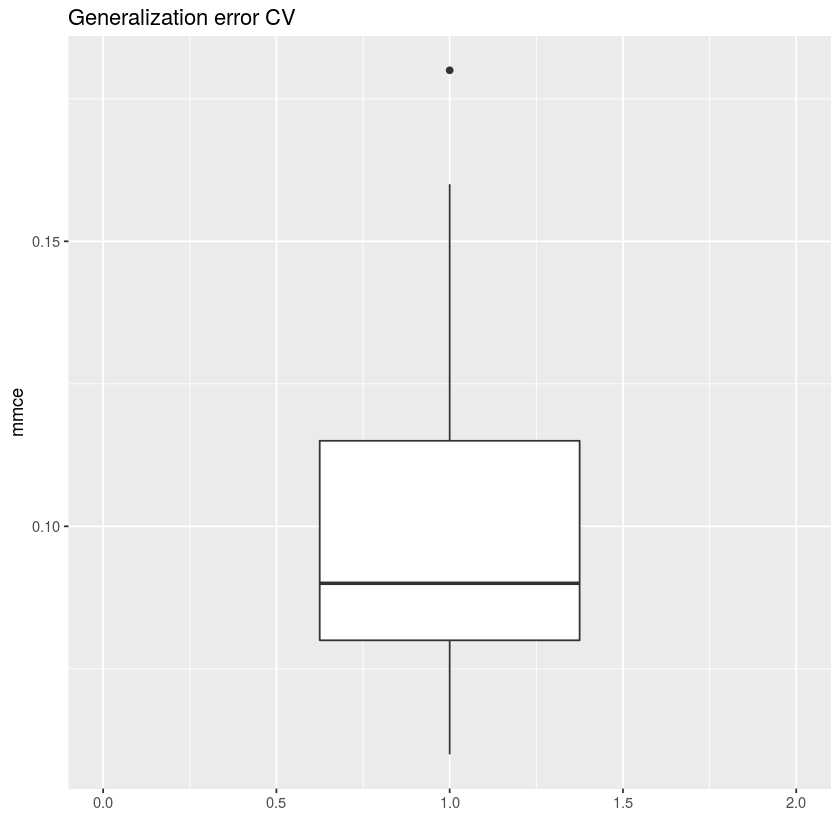

In [74]:
p = ggplot(data = foo$storage, aes(y = storage, x = 1)) +
  geom_boxplot() +
  ggtitle(label = "Generalization error CV") +
  xlab("") + ylab("mmce") + xlim(c(0,2))
p

### mlr's CV implementation

In [75]:
set.seed(1337)
task = mlr::makeClassifTask(data = spiral, target = "classes")
rdescCV = mlr::makeResampleDesc(method = "CV", iters = 10)
mlrCV = resample(learner = "classif.knn", k = 3, task = task,
  resampling = rdescCV, show.info = FALSE)
mlrCV
mlrCV$measures.test

Resample Result
Task: spiral
Learner: classif.knn
Aggr perf: mmce.test.mean= 0.1
Runtime: 0.0330875

iter,mmce
1,0.14
2,0.08
3,0.04
4,0.04
5,0.14
6,0.08
7,0.10
8,0.10
9,0.14
10,0.14


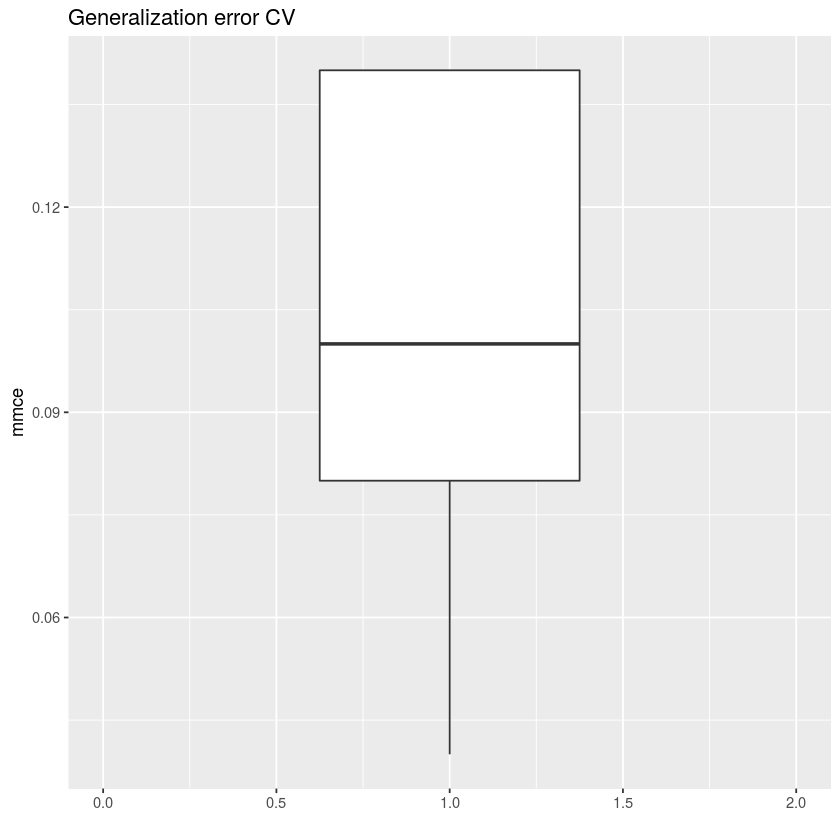

In [76]:
p = ggplot(data = mlrCV$measures.test, aes(y = mmce, x = 1)) +
  geom_boxplot() +
  ggtitle(label = "Generalization error CV") +
  xlab("") + ylab("mmce") + xlim(c(0,2))
p

## 3. Nested Resampling 

   

No we want to find the optimal hyperparameter k for our model. Therefore we use nested resampling with the following options:
* 5 outer CV loops
* 10 inner CV loops
* 7 Candidates (like in lecture slides 3.3)

Check scheme for nested resampling algorithm on the blackboard. 


In [77]:
selfNR = function(data, target, outerFolds = 3, innerFolds = 4, kCandidates, inform = FALSE) {
  
  # counter for inform functionality
  counter = 0
  
  set.seed(1337)
  # indices for the outer loops
  outerIndices = sample(x = seq(1, nrow(data), by = 1), size = nrow(data), replace = FALSE)
  indexOuterMat = matrix(data = outerIndices, byrow = TRUE, nrow = outerFolds)
  
  # frame to store the winner and its test-GE from all outer folds
  winnerCV = as.data.frame(matrix(0, nrow = outerFolds, ncol = 2))
  colnames(winnerCV) = c("k", "GE")
  
  for (i in 1:outerFolds) {
    
    # split in validation and data for the inner loop
    valData = data[indexOuterMat[i, ], ]
    innerData = data[ -indexOuterMat[i, ], ]
    
    # frame to store the CV-GEs for each candidate
    candidateGE = as.data.frame(matrix(0, nrow = length(kCandidates), ncol = 2))
    colnames(candidateGE) = c("k", "GE")
    
    # calculate GE for each of the candidates via CV
    for (l in 1:length(kCandidates)) {
      
      innerIndices = sample(x = seq(1, nrow(innerData), by = 1), size = nrow(innerData), replace = FALSE)
      
      # index matrix for inner folds
      indexInnerMat = matrix(data = innerIndices, byrow = TRUE, nrow = innerFolds)
      
      # storage for CV errors for one candidate
      storageInnerCV = numeric(innerFolds)
      
      for (j in 1:innerFolds) {
        # data
        testData = innerData[indexInnerMat[j, ], ]
        trainData = innerData[ -indexInnerMat[j, ], ]
        
        # model
        task = makeClassifTask(data = trainData, target = target)
        learner = makeLearner("classif.kknn", k = kCandidates[l])
        model = train(learner = learner, task = task)
        # inform user about progress
        counter = counter + 1
        if (inform) print(paste0("model: " ,counter, " inner fold: ", j, " outer fold: ", i))
        storageInnerCV[j] = performance(predict(model, newdata = testData),
          measures = mmce)[[1]]
      }
      
      # CV GE for candidate l
      candidateGE[l, "GE"] = mean(storageInnerCV)
      candidateGE[l, "k"] = kCandidates[l]
    }
    
    # get GE for best candidate in this outerFold
    # in case of equally good Candidates, choose the first one
    bestCandidate = candidateGE[which(candidateGE$GE == min(candidateGE$GE)), "k"][1]
    winnerCV[i, "k"] = bestCandidate
    
    
    # model
    task = makeClassifTask(data = innerData, target = target)
    learner = makeLearner("classif.kknn", k = kCandidates[l])
    model = train(learner = learner, task = task)
    winnerCV[i, "GE"] = performance(predict(model, newdata = valData),
      measures = mmce)[[1]]
  }
  return(winnerCV[order(winnerCV$GE), ])
}

In [78]:
# let's run it
resultNR = selfNR(data = spiral, target = "classes", outerFolds = 10, innerFolds = 10,
  kCandidates = c(1, 3, 5, 10, 20, 30, 40, 100), inform = FALSE)
# order results by GE
resultNR

,k,GE
6,20,0.06
2,5,0.08
3,30,0.08
4,40,0.08
10,30,0.10
7,10,0.12
8,20,0.12
9,20,0.16
5,10,0.20
1,10,0.26


### Use only CV for Hyperparameter Selection:



In [79]:
tuneCV = function(data, target, folds, kCandidates) {
  
  candidatesGE = as.data.frame(matrix(data = 0, nrow = length(kCandidates), ncol = 2))
  colnames(candidatesGE) = c("k", "GE")

  for (l in 1:length(kCandidates)) {
    
    candidatesGE[l, "k"] = kCandidates[l]
    candidatesGE[l, "GE"] = selfCV(data = data, target = target, folds = folds, 
      k = kCandidates[l])$GE
  }  
  return(candidatesGE[order(candidatesGE$GE), ])
}


resultCV = tuneCV(data = spiral, target = "classes", folds = 10, kCandidates = c(1, 3, 5, 10, 20, 30, 40, 100))
resultCV

,k,GE
3,5,0.074
4,10,0.076
7,40,0.078
5,20,0.080
6,30,0.080
1,1,0.102
2,3,0.102
8,100,0.126


### Test the hyperparameters on completely unseen data

Test the hyperparameters proposed by nested resampling and cross-validation on completely new data, that none of the two algorithms have seen before. Neat thing about the spiral data: we can simulate new data points whenever we want!

What would we expect based on the lecture?

An overly optimistic estimate for the perfect hyperparameter by simple CV (overtuning effect) and a more realistic estimate from the nested resampling algorithm. 


#### Nested Resampling Hyperparameter

In [80]:
set.seed(1337)
unseenSpiral = as.data.frame(mlbench.spirals(n = 200, sd = 0.1))

task = makeClassifTask(data = spiral, target = "classes")
learner = makeLearner("classif.kknn", k = 20)
model = train(learner = learner, task = task)
print(paste0("nested RS k = 20: ", performance(predict(model, newdata = unseenSpiral), measures = mmce)[[1]], 
     " with NR GE estimate: ", resultNR[1, 2]))


[1] "nested RS k = 20: 0.055 with NR GE estimate: 0.06"


#### Simple Cross-Validation Hyperparameter

In [81]:
set.seed(1337)
unseenSpiral = as.data.frame(mlbench.spirals(n = 200, sd = 0.1))

task = makeClassifTask(data = spiral, target = "classes")
learner = makeLearner("classif.kknn", k = 5)
model = train(learner = learner, task = task)
print(paste0("CV tuned k = 5: ", performance(predict(model, newdata = unseenSpiral), measures = mmce)[[1]], 
            " with CV GE estimate: ",resultCV[1, 2]))


[1] "CV tuned k = 5: 0.085 with CV GE estimate: 0.074"


# Problems:
* results are very depending on the seed
* CV from mlr delievers other results than the self implemented version
* We want to show that CV is too optimistic concerning the estimation of the Generalization error. This does currently work for the k = 5 parameter (estimated GE: 0.074, real: 0.085) whereas the GE for the nested resampling k is similar to the performance on the totally unseen data. 
* Discuss how to choose the winning hyperparameter from the nested resampling output. They will ask, why k=20 yields errors of 0.06 and 0.12 and how to deal with that - we should be able to answer that question. 



### mlr implementation

In [82]:
ps = makeParamSet(
  makeDiscreteParam("k", values = c(1, 3, 5, 10, 20, 30, 40))
)

ctrl = makeTuneControlGrid()
rdesc = makeResampleDesc("CV", iters = 10L)
task = makeClassifTask(data = spiral, target = "classes")
res = tuneParams("classif.knn", task = task, resampling = rdesc,
  par.set = ps, control = ctrl)


[Tune] Started tuning learner classif.knn for parameter set:
      Type len Def            Constr Req Tunable Trafo
k discrete   -   - 1,3,5,10,20,30,40   -    TRUE     -
With control class: TuneControlGrid
Imputation value: 1
[Tune-x] 1: k=1
[Tune-y] 1: mmce.test.mean= 0.1; time: 0.0 min
[Tune-x] 2: k=3
[Tune-y] 2: mmce.test.mean=0.082; time: 0.0 min
[Tune-x] 3: k=5
[Tune-y] 3: mmce.test.mean=0.074; time: 0.0 min
[Tune-x] 4: k=10
[Tune-y] 4: mmce.test.mean=0.068; time: 0.0 min
[Tune-x] 5: k=20
[Tune-y] 5: mmce.test.mean=0.076; time: 0.0 min
[Tune-x] 6: k=30
[Tune-y] 6: mmce.test.mean=0.082; time: 0.0 min
[Tune-x] 7: k=40
[Tune-y] 7: mmce.test.mean=0.102; time: 0.0 min
[Tune] Result: k=10 : mmce.test.mean=0.068


## 4. Confusion matrices, ROC, AUC and unbalanced data

We use the Breast Cancer data set from [UCI database](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) which is an __unbalanced data set__ within which we want to predict the class of the cancer. We even manipulate the data set further to make it more unbalanced. 

The data looks like that:





In [83]:
library("dplyr")
data("BreastCancer")

# delete one column with missing values
bc = BreastCancer[, -c(1, 7)]
# mutate all factors to numeric, simlification but ok here
mut = bc[, -9] %>% mutate_all(as.character) %>% mutate_all(as.numeric)
bcData = cbind(mut, bc$Class)
colnames(bcData) = c(colnames(mut), "Class")
# make it more extreme and kill 50% of the malignant data
bcData = bcData[ -sample(which(bcData$Class == "malignant"), 150, replace = FALSE), ]
head(bcData)
table(bcData$Class) / sum(table(bcData$Class))


,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bl.cromatin,Normal.nucleoli,Mitoses,Class
1,5,1,1,1,2,3,1,1,benign
2,5,4,4,5,7,3,2,1,benign
3,3,1,1,1,2,3,1,1,benign
4,6,8,8,1,3,3,7,1,benign
5,4,1,1,3,2,3,1,1,benign
7,1,1,1,1,2,3,1,1,benign



   benign malignant 
0.8342441 0.1657559 

We split the data again in train and test and check the performance of two classifiers:
1. Good old knn
2. A stupid learner that simply predicts the majority of the two classes or each obsveration. 

The problem is now, that even the stupid approach yields a reasonable mmce performance. Thus, we need additional measure such as the AUC and ROC curves to compare the two classifiers.

In [84]:
# Data split
trainSize = 3/4
trainIndices = sample(x = seq(1, nrow(bcData), by = 1), size = ceiling(trainSize * nrow(bcData)), replace = FALSE)
bcTrain = bcData[ trainIndices, ]
bcTest = bcData[ -trainIndices, ]

task = makeClassifTask(data = bcTrain, target = "Class")

Knn:





In [85]:
# knn
learner = makeLearner("classif.kknn", k = 5, predict.type = "prob")
model = mlr::train(learner, task)
predKnn = predict(model, newdata = bcTest)
performance(predKnn, measures = list(mmce, auc))
calculateConfusionMatrix(predKnn)

mmce        auc 
0.05109489 0.95609504

           predicted
true        benign malignant -err.-
  benign       116         5      5
  malignant      2        14      2
  -err.-         2         5      7

Stupid majority vote:

In [86]:

# learner that uses simple majority vote for classification
stupidLearner = makeLearner("classif.featureless", method = "majority", predict.type = "prob")
model = mlr::train(stupidLearner, task)
predStupid = predict(model, newdata = bcTest)
performance(predStupid, measures = list(mmce, auc))
calculateConfusionMatrix(predStupid)

mmce       auc 
0.1167883 0.5000000

           predicted
true        benign malignant -err.-
  benign       121         0      0
  malignant     16         0     16
  -err.-        16         0     16

Compare the ROC curves:


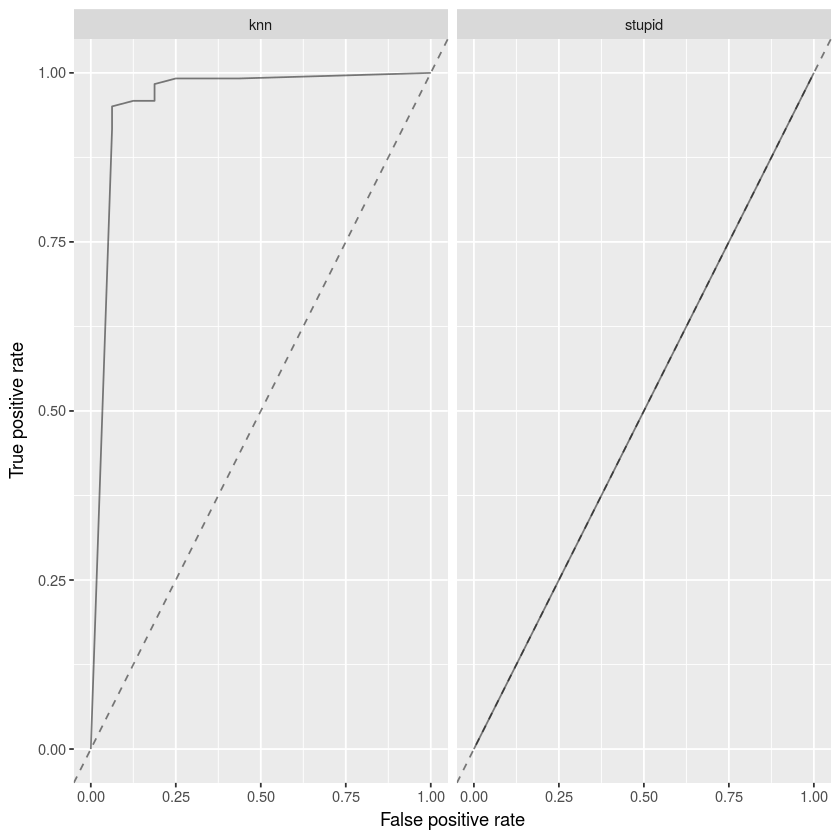

In [87]:
rocs = generateThreshVsPerfData(list(knn = predKnn, stupid = predStupid), measures = list(fpr, tpr, mmce))
plotROCCurves(rocs)